# Normalization and batch correction

## Settings

#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

In [128]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Esophagus'

In [129]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method='total'  # can be 'tfidf' or 'total'
log_normalize=True

# Options for highly variable genes
min_score = None

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_correction=False

# save figures
save_figs = False

## Loading packages and setup

In [130]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [131]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [132]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 45493 × 148047
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## Find highly variable features

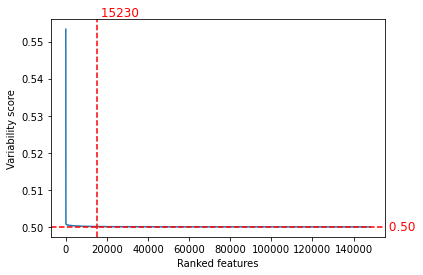

In [133]:
get_variable_features(adata, min_score=0.5001, show=True, inplace=True)

In [134]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

15230

In [88]:
adata.var['variability_score']

0         0.500088
2         0.500000
5         0.500000
6         0.500000
7         0.500088
            ...   
150125    0.500044
150126    0.500044
150127    0.500022
150128    0.500022
150129    0.500000
Name: variability_score, Length: 148047, dtype: float64

In [51]:
adata.obs_names.tolist()

['AAACTACCAGAAACCCGAGATA',
 'AAACTACCAGAAACCTAAGTGG',
 'AAACTACCAGAAACGGATCAGT',
 'AAACTACCAGAAACTAGCCCTA',
 'AAACTACCAGAAAGCACTAGCG',
 'AAACTACCAGAAAGCCCACGAC',
 'AAACTACCAGAAAGCGGGAGCT',
 'AAACTACCAGAAAGGAACAGAC',
 'AAACTACCAGAAAGGATCGGCT',
 'AAACTACCAGAAAGGGATGCCA',
 'AAACTACCAGAAAGTCGCGTGT',
 'AAACTACCAGAAATAAGGCCAG',
 'AAACTACCAGAAATGCTACGGG',
 'AAACTACCAGAAATTGAGGAGG',
 'AAACTACCAGAACAGGCGGGTA',
 'AAACTACCAGAACATGAAGCGC',
 'AAACTACCAGAACCACCTAAAG',
 'AAACTACCAGAACCATGCATGA',
 'AAACTACCAGAACCCACTATCT',
 'AAACTACCAGAACCGAATTCTC',
 'AAACTACCAGAACCGCTAATGA',
 'AAACTACCAGAACGAGCTGTGA',
 'AAACTACCAGAACGTGATTTGG',
 'AAACTACCAGAACTGCGTCTTT',
 'AAACTACCAGAACTTCGACCAG',
 'AAACTACCAGAACTTGCTCACC',
 'AAACTACCAGAAGACACCAACC',
 'AAACTACCAGAAGCGGAACCTA',
 'AAACTACCAGAAGCGGGCTTGA',
 'AAACTACCAGAAGCTAACGCAC',
 'AAACTACCAGAAGCTCAACGCA',
 'AAACTACCAGAAGCTCTCTGAT',
 'AAACTACCAGAAGGGCAAATCA',
 'AAACTACCAGAAGTAGCCCGCT',
 'AAACTACCAGAAGTGTCGTGGA',
 'AAACTACCAGAAGTTGTGCTAC',
 'AAACTACCAGAATATAGGTCCG',
 

In [94]:
adata.var['prop_shared_cells'] = adata.var['prop_shared_cells']*1000
adata.var['prop_shared_cells']

0         8.792561
2         0.000000
5         0.000000
6         0.000000
7         8.792561
            ...   
150125    4.396281
150126    4.396281
150127    2.198140
150128    2.198140
150129    0.000000
Name: prop_shared_cells, Length: 148047, dtype: float64

In [65]:
adata.var['n_cells'] = adata.X.sum(axis=0).tolist()[0] ## double check this
adata.var['prop_shared_cells'] = adata.var['n_cells']/len(adata.obs_names.tolist())
adata.var['variability_score'] = [1-abs(n-0.5) for n in adata.var['prop_shared_cells']]

0         0.087926
2         0.000000
5         0.000000
6         0.000000
7         0.087926
            ...   
150125    0.043963
150126    0.043963
150127    0.021981
150128    0.021981
150129    0.000000
Name: prop_shared_cells, Length: 148047, dtype: float64

In [121]:
def get_variable_features(adata, min_score=None, gain=1, show=True, inplace=True):
    """
    Get the highly variable features of anndata object. Adds the columns "highly_variable" and "variability_score" to adata.obs. If show is True, the plot is shown.

    Parameters
    -----------
    adata : anndata.AnnData
        The anndata object containing counts for variables.
    min_score : float, optional
        The minimum variability score to set as threshold. Default: None (automatic)
    show : bool
        Show plot of variability scores and thresholds. Default: True.
    inplace : bool
        If True, the anndata object is modified. Otherwise, a new anndata object is returned. Default: True.

    Returns
    --------
    If inplace is False, the function returns None
    If inplace is True, the function returns an anndata object.
    """
    utils.check_module("kneed")
    utils.check_module("statsmodels")

    from kneed import KneeLocator
    import statsmodels.api as sm

    if inplace is False:
        adata = adata.copy()

    # Calculate variability
    adata.var['n_cells'] = adata.X.sum(axis=0).tolist()[0] ## double check this
    adata.var['prop_shared_cells'] = (adata.var['n_cells']/len(adata.obs_names.tolist()))*gain
    adata.var['variability_score'] = [1-abs(n-0.5) for n in adata.var['prop_shared_cells']]

    # Set threshold
    if min_score is None:

        # Get input data to fit
        scores = adata.var["variability_score"].sort_values(ascending=False)
        x = np.arange(len(scores))

        # Subset data to reduce computational time
        target = 10000
        step = int(len(scores) / target)
        if step > 0:
            idx_selection = np.arange(len(scores), step=step)
            scores = scores[idx_selection]
            x = x[idx_selection]

        # Smooth using lowess (prevents early finding of knees due to noise)
        scores = sm.nonparametric.lowess(scores, x, return_sorted=False, frac=0.05)

        # Find knee
        kneedle = KneeLocator(x, scores, curve="convex", direction="decreasing", online=False)
        min_score = kneedle.knee_y

    # Set "highly_variable" column in var
    adata.var["highly_variable"] = adata.var["variability_score"] >= min_score
    n_variable = adata.var["highly_variable"].sum()

    # Create plot
    if show is True:
        _, ax = plt.subplots()

        # Plot distribution of scores
        scores = adata.var["variability_score"].sort_values(ascending=False)
        x = np.arange(len(scores))
        ax.plot(x, scores)

        # Horizontal line at knee
        ax.axhline(min_score, linestyle="--", color="r")
        xlim = ax.get_xlim()
        ax.text(xlim[1], min_score, " {0:.2f}".format(min_score), fontsize=12, ha="left", va="center", color="red")

        # Vertical line at knee
        ax.axvline(n_variable, linestyle="--", color="r")
        ylim = ax.get_ylim()
        ax.text(n_variable, ylim[1], " {0:.0f}".format(n_variable), fontsize=12, ha="left", va="bottom", color="red")

        ax.set_xlabel("Ranked features")
        ax.set_ylabel("Variability score")

    # Return the copy of the adata
    if inplace is False:
        return adata

## Normalization

In [135]:
# Consider using parts of sctoolbox.analyser

In [136]:
if norm_method == 'tfidf':
    epi.pp.tfidf(adata, norm='l1', layer_tfidf_key='tf-idf')
if norm_method == 'total':
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
#if not norm_method:
#    atac_norm(adata)  #a function that performs both norm methods and pca for each method, then plots so the user can choose

In [137]:
if log_normalize:
    epi.pp.log1p(adata)

## PCA

In [138]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

## Calc Neighbours

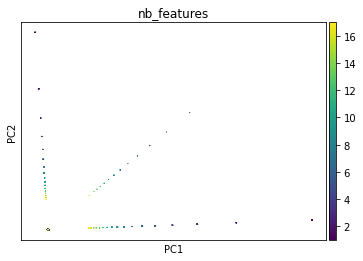

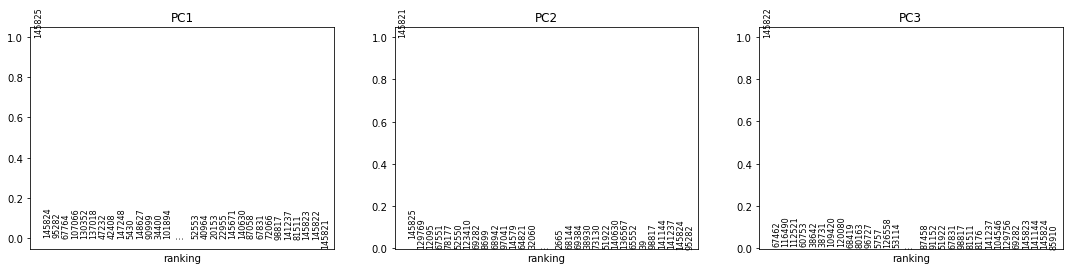

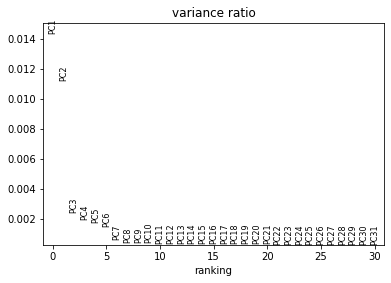

In [139]:
# Change to module
if save_figs:
    epi.pl.pca_overview(adata, color=['nb_features'], show=False)
    #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
    plt.show()
else:
    epi.pl.pca_overview(adata, color=['nb_features'])

In [140]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

## UMAP

Computing UMAPs:   0%|          | 0/8 [00:00<?, ?it/s]

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


array([[<AxesSubplot:title={'center':'min_dist: 0.1'}, ylabel='spread: 2.0'>,
        <AxesSubplot:title={'center':'min_dist: 0.2'}>,
        <AxesSubplot:title={'center':'min_dist: 0.3'}>,
        <AxesSubplot:title={'center':'min_dist: 0.4'}>],
       [<AxesSubplot:ylabel='spread: 2.5'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

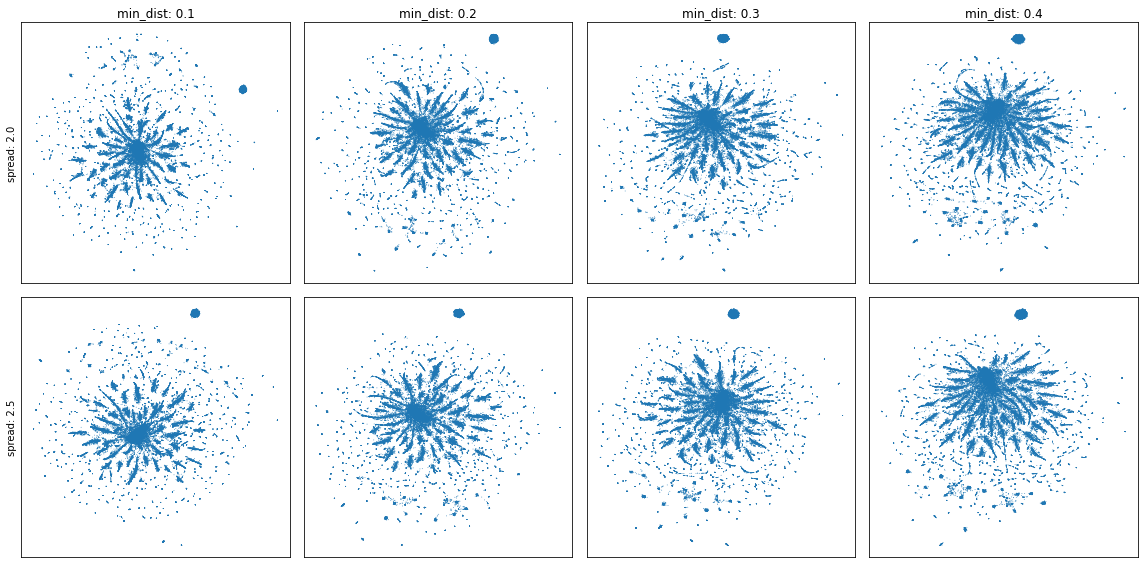

In [141]:
search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol='sample', 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Plot

## Batch correction

In [ ]:
#Consider 

## save anndata